In [1]:
import numpy as np
import scipy as sp
import scipy.signal as sig
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, regularizers, callbacks
from sklearn.decomposition import PCA
from data_wrangling.datamanager import DataLoader

In [2]:
dl = DataLoader()
data = dl.get_fcx2(['s1'])

In [3]:
X1 = data['s1']['data']
mn = X1.mean(0).reshape((1, -1))
st = X1.std (0).reshape((1, -1))
X1 = (X1 - mn) / st
X1.shape

(1303952, 73)

In [4]:
fs = 1000

idxs_train_test_split = int(len(X1) * 0.7)

t_in  = 2e-1
t_out = 2e-2

p_in  = int(fs * t_in)
p_out = int(fs * t_out)

step  = int(fs * 8e-3) 

idxs_train = np.arange(0, idxs_train_test_split - p_out - p_in, step)

X_train = np.stack([
    X1[idx : idx + p_in]
    for idx in idxs_train
])

Y_train = np.stack([
    X1[idx + p_in : idx + p_in + p_out]
    for idx in idxs_train
])

X_train.shape, Y_train.shape

((114069, 200, 73), (114069, 20, 73))

In [5]:
def make_model_architecture_1(
    X, Y,
    
    dense_pre_n_layers,
    dense_pre_n_units,
    
    bidirectional_encoder_n_layers,
    bidirectional_encoder_n_units,
    
    dense_mid_n_layers,
    dense_mid_n_units,
    
    lstm_decoder_n_units,
    
    bidirectional_decoder_n_layers,
    bidirectional_decoder_n_units,
    
    dense_post_n_layers,
    dense_post_n_units
):
    '''
        Architecture:
        
        X (input) shape (n timesteps in, n channels)
        
        dense_pre_n_layers number of:
            Dense(dense_pre_n_units)
            BatchNormalization
            ReLU
            
        (bidirectional_encoder_n_layers - 1) number of:
            Bidirectional(
                LSTM(
                    bidirectional_encoder_n_units,
                    return_sequences = True
                )
            )
            
        Bidirectional(
            LSTM(
                bidirectional_encoder_n_units,
                return_sequences = False
            )
        )
            
        dense_mid_n_layers number of:
            Dense(dense_mid_n_units)
            BatchNormalization
            ReLU
            
        RepeatVector(n timesteps out)
        LSTM(
            lstm_decoder_n_units,
            return_sequences = True
        )
        
        bidirectional_decoder_n_layers number of:
            Bidirectional(
                LSTM(
                    bidirectional_decoder_n_units,
                    return_sequences = True
                )
            )
        
        dense_post_n_layers number of:
            Dense(dense_post_n_units)
            BatchNormalization
            ReLU
            
        Dense(n channels) shape (n timesteps out, n channels)
        
    '''
    
    def dense_unit(units):
        return [
            layers.Dense(units),
            layers.BatchNormalization(),
            layers.ReLU()
        ]
    
    def bidirectional_unit(units, return_sequences):
        return layers.Bidirectional(
            layers.LSTM(
                units,
                return_sequences = return_sequences
            )
        )
    
    model = keras.Sequential()
    model.add(layers.Input(X.shape[1:]))
    
    for i in range(dense_pre_n_layers):
        for l in dense_unit(dense_pre_n_units):
            model.add(l)
            
    for i in range(bidirectional_encoder_n_layers - 1):
        model.add(bidirectional_unit(bidirectional_encoder_n_units, True))
    model.add(bidirectional_unit(bidirectional_encoder_n_units, False))
    
    for i in range(dense_mid_n_layers):
        for l in dense_unit(dense_mid_n_units):
            model.add(l)
    
    model.add(layers.RepeatVector(Y.shape[1]))
    model.add(layers.LSTM(
        lstm_decoder_n_units,
        return_sequences = True
    ))
    
    for i in range(bidirectional_decoder_n_layers):
        model.add(bidirectional_unit(bidirectional_decoder_n_units, True))
    
    for i in range(dense_post_n_layers):
        for l in dense_unit(dense_post_n_units):
            model.add(l)
            
    model.add(layers.Dense(Y.shape[-1]))
    model.compile(loss = 'mse', optimizer = 'adam')
    return model

In [6]:
model = make_model_architecture_1(
    X_train, Y_train,
    0, 0,
    1, 64,
    0, 0,
    128,
    1, 64,
    0, 0
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 128)               70656     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 20, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 128)           131584    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 128)           98816     
_________________________________________________________________
dense (Dense)                (None, 20, 73)            9417      
Total params: 310,473
Trainable params: 310,473
Non-trainable params: 0
_________________________________________________________________


In [7]:
hist = model.fit(
    X_train,
    Y_train,
    epochs = 20,
    batch_size = 512,
    validation_split = 0.2
)

Epoch 1/20
179/179 [==============================] - 17s 74ms/step - loss: 0.5442 - val_loss: 0.2654
Epoch 2/20
179/179 [==============================] - 12s 65ms/step - loss: 0.2184 - val_loss: 0.2071
Epoch 3/20
179/179 [==============================] - 12s 64ms/step - loss: 0.1773 - val_loss: 0.1884
Epoch 4/20
179/179 [==============================] - 12s 65ms/step - loss: 0.1591 - val_loss: 0.1717
Epoch 5/20
179/179 [==============================] - 12s 64ms/step - loss: 0.1476 - val_loss: 0.1641
Epoch 6/20
179/179 [==============================] - 12s 65ms/step - loss: 0.1409 - val_loss: 0.1607
Epoch 7/20
179/179 [==============================] - 12s 66ms/step - loss: 0.1365 - val_loss: 0.1548
Epoch 8/20
179/179 [==============================] - 12s 66ms/step - loss: 0.1325 - val_loss: 0.1532
Epoch 9/20
179/179 [==============================] - 12s 66ms/step - loss: 0.1303 - val_loss: 0.1495
Epoch 10/20
179/179 [==============================] - 12s 66ms/step - loss: 0.126

In [8]:
hist = model.fit(
    X_train,
    Y_train,
    epochs = 20,
    batch_size = 128,
    validation_split = 0.3
)

Epoch 1/20
624/624 [==============================] - 18s 29ms/step - loss: 0.1688 - val_loss: 0.1580
Epoch 2/20
624/624 [==============================] - 17s 26ms/step - loss: 0.1321 - val_loss: 0.1451
Epoch 3/20
624/624 [==============================] - 16s 26ms/step - loss: 0.1232 - val_loss: 0.1399
Epoch 4/20
624/624 [==============================] - 16s 26ms/step - loss: 0.1212 - val_loss: 0.2487
Epoch 5/20
624/624 [==============================] - 16s 26ms/step - loss: 0.1349 - val_loss: 0.1433
Epoch 6/20
624/624 [==============================] - 16s 26ms/step - loss: 0.1159 - val_loss: 0.1384
Epoch 7/20
624/624 [==============================] - 16s 26ms/step - loss: 0.1134 - val_loss: 0.1380
Epoch 8/20
624/624 [==============================] - 17s 27ms/step - loss: 0.1117 - val_loss: 0.1361
Epoch 9/20
624/624 [==============================] - 16s 26ms/step - loss: 0.1162 - val_loss: 0.1388
Epoch 10/20
624/624 [==============================] - 16s 26ms/step - loss: 0.109

In [9]:
pred = []
real = []
for idx in range(idxs_train_test_split, len(X1) - p_out - p_in, p_out):
    x = X1[idx : idx + p_in].reshape((1, p_in, -1))
    y = X1[idx + p_in : idx + p_in + p_out]
    pred.append(x)
    real.append(y)
    
per_stride = 512
strides = int(len(pred) / per_stride) + 1
pred = np.concatenate([
    model(
        np.concatenate(pred[stride * per_stride : (stride + 1) * per_stride])
    ).numpy()
    for stride in range(strides)
])

real = np.stack(real)

pred.shape, real.shape

((19549, 20, 73), (19549, 20, 73))

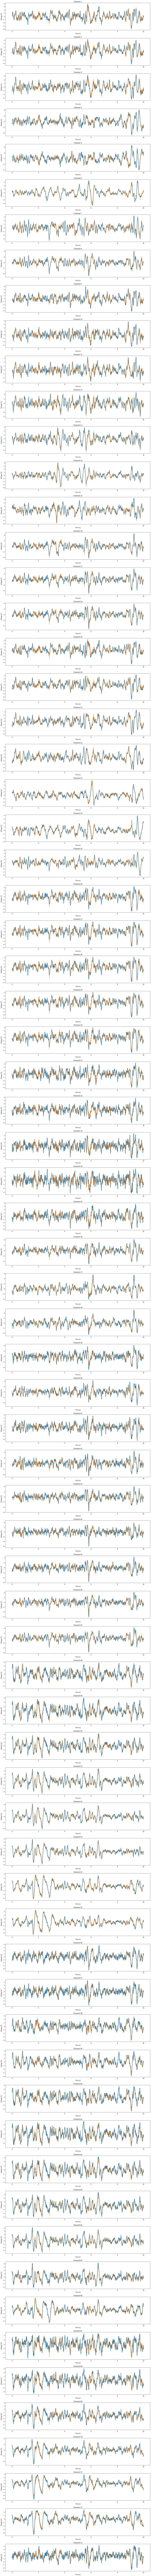

In [10]:
n_channels = real.shape[-1]
plt.figure(figsize = (20, 5 * n_channels))
n_steps = 500
plt.subplots_adjust(hspace = 0.3)

for chan in range(real.shape[-1]):

    plt.subplot(n_channels, 1, chan + 1)
    plt.title(f'Channel {chan + 1}')
    plt.plot(
        np.linspace(0, p_out * n_steps / fs, n_steps * p_out), 
        real[:n_steps, :, chan].flatten(), 
        linewidth = 3
    )
    plt.plot(
        np.linspace(0, p_out * n_steps / fs, n_steps * p_out), 
        pred[:n_steps, :, chan].flatten(), 
        linewidth = 1
    )
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [V]')
    
plt.show()